In [1]:
# Import libraries
import numpy as np
from matplotlib import pyplot as plt  
from brian2 import *
time = 10000

In [2]:
with open("../parameter.h", 'r') as file:
    output = [ line.strip().split(' ') for line in file.readlines()]
    for i in output:
        del i[0]
        i[1] = float(i[1]) 
for i in output:
    globals()['{}'.format(i[0])] = i[1]

In [3]:
# Execution of Cocotb simulation
%cd /home/huiseong/neuron_workspace/neuron07_code_clear/testbench
!make

/home/huiseong/neuron_workspace/neuron07_code_clear/testbench
make results.xml
make[1]: Entering directory '/home/huiseong/neuron_workspace/neuron07_code_clear/testbench'
/usr/bin/iverilog -o sim_build/sim.vvp -D COCOTB_SIM=1 -s neuron07 -f sim_build/cmds.f -g2012   /home/huiseong/neuron_workspace/neuron07_code_clear/testbench/../parameter.h /home/huiseong/neuron_workspace/neuron07_code_clear/testbench/../hdl/neuron07.v
MODULE=coco_bench  TESTCASE= TOPLEVEL=neuron07 TOPLEVEL_LANG=verilog \
        /usr/bin/vvp -M /usr/local/lib/python3.8/dist-packages/cocotb-1.6.0.dev0-py3.8-linux-x86_64.egg/cocotb/libs -m libcocotbvpi_icarus   sim_build/sim.vvp 
     -.--ns INFO     cocotb.gpi                         ..mbed/gpi_embed.cpp:76   in set_program_name_in_venv        Did not detect Python virtual environment. Using system-wide Python interpreter
     -.--ns INFO     cocotb.gpi                         ../gpi/GpiCommon.cpp:99   in gpi_print_registered_impl       VPI registered
     -.--ns INFO

In [288]:
input_value    = np.load('./data_numpy/input_spikes.npy')
internal_state = np.load('./data_numpy/internal_voltage.npy')
output_spike   = np.load('./data_numpy/output_spikes.npy')
rst_vol        = np.load('./data_numpy/rst_vol.npy')
thr_vol        = np.load('./data_numpy/thr_vol.npy')

In [289]:
# Generating boolean array for visualizing input spikes under the graph
input_spikes_boolean = np.zeros(time)
for i in range(time):
    if(input_value[i]>0):
        input_spikes_boolean[i]=1
    else:
        input_spikes_boolean[i]=0

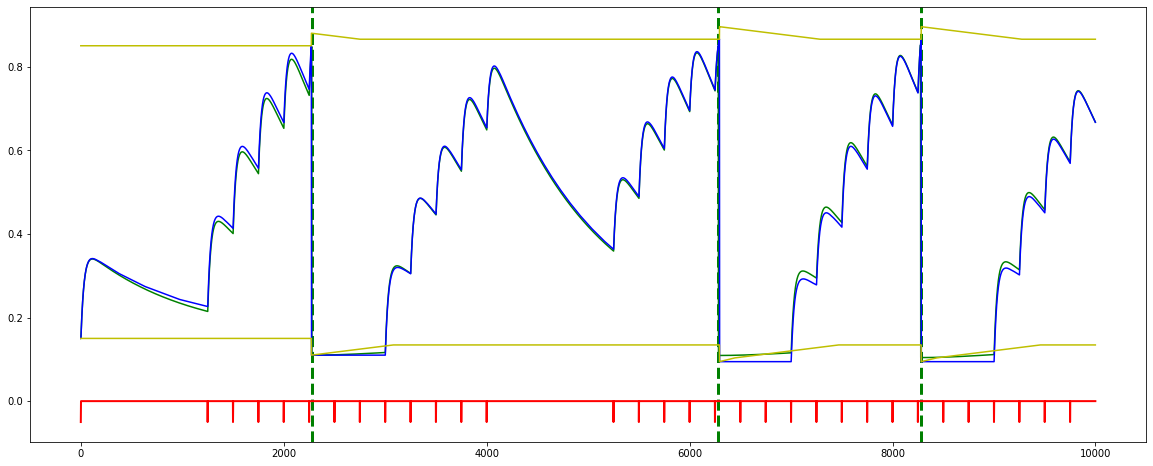

In [290]:
figure(figsize=(20,8))  # config plot size
start_scope()
dt = 1*ms

stimulus = TimedArray((list(input_value)*mV)/(2**H_INTERNAL_VOLTAGE_RESOULTION_BITS), dt=1*ms)

# 32가 data length가 아니고 spike accumulation의 TAU값인 32임
# 세번째 dI/dt 보면 입력스파이크(순수하게 전부) + 현재 입력값의 32분할(TAU)만큼 빼준거(더했을 테니까 그만큼 빼주는거)
# 이게 버퍼 역할이 됨 I가 버퍼임 그 버퍼를 첫째줄 dv/dt에서 TAU인 32로 다시 쪼개서 exponential하게 더해주는 것
eqs = ''' 
dv/dt = I/(H_TAU_BUF*ms) + (-v+rst)/(H_TAU_INT*ms)  : volt 
dvt/dt = (H_MIN_THRESHOLD_VOLTAGE_RATIO*mV - vt)/(H_TAU_THR*ms) : volt
dI/dt = stimulus(t)/ms - I/(H_TAU_BUF*ms) : volt (unless refractory)
drst/dt = (H_MAX_RESTING_VOLTAGE_RATIO*mV - rst)/(H_TAU_RST*ms) : volt
'''

eqs_rst='''
vt = vt + H_THRESHOLD_CONTRIBUTION_RATIO*mV
rst = rst - H_RESTING_CONTRIBUTION_RATIO*mV
v = rst
I=0*mV
'''
G = NeuronGroup(1, eqs, threshold='v > vt', reset=eqs_rst, dt=1*ms, refractory=H_CLK_COUNT*ms, method='euler')
G[0].vt = H_MIN_THRESHOLD_VOLTAGE_RATIO*mV
G[0].v = H_MAX_RESTING_VOLTAGE_RATIO*mV
G[0].rst = H_MAX_RESTING_VOLTAGE_RATIO*mV #################################################3
spikemon = SpikeMonitor(G)
M = StateMonitor(G, 'v', record=0)
run(time*ms)
#2**32*0.1*0.01
# Plot the brian2 simulation results, color is green
plt.plot(M.t/ms, M.v[0]*1000,color='g')
for t in spikemon.t:
    axvline(t/ms, ls='--', c='g', lw=3)

# Plot the cocotb simulation results, BLUE : COCOTB INTERNAL STATES
plt.plot(M.t/ms,internal_state/(2**H_INTERNAL_VOLTAGE_RESOULTION_BITS),color='b')

# Plot the cocotb simulation results, resting voltage
plt.plot(M.t/ms,rst_vol/(2**H_INTERNAL_VOLTAGE_RESOULTION_BITS),color='y')

# Plot the cocotb simulation results, threshold voltage
plt.plot(M.t/ms,thr_vol/(2**H_INTERNAL_VOLTAGE_RESOULTION_BITS),color='y')

# Plot the input spikes(not value, just boolean), color is red
plt.plot(M.t/ms, input_spikes_boolean/-20,linewidth=2,color='r')